Bibliotecas utilizadas en el código

In [ ]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import pandas as pd

Clase general de datos

In [ ]:
class datos:
    def __init__(self, x, y):
        self.x = x
        self.y = y

Función para graficar

In [ ]:
def graficar(interpolacion: Callable, intervalo: np.array,real: Callable=None ):
    if(real!=None):
       y_real=real(intervalo)
       plt.plot(intervalo,y_real)
    y_interpolable=interpolacion(intervalo)
    plt.plot(intervalo,y_interpolable)
    plt.grid(True)

Interpolación de Lagrange

In [ ]:
def Lagrange(f: list, p, n: int ) -> float:
    # Inicializamos el resultado
    polinomio_resultante = 0.0
    for i in range(n):
        #calculamos el polinomio
        term = f[i].y
        for j in range(n):
            if j != i:
                term = term * (p - f[j].x) / (f[i].x - f[j].x)

        #Agregamos el resultado
        polinomio_resultante += term
    return polinomio_resultante

In [ ]:
#x 1.0 1.3 1.6 1.9 2.2
#f (x) 0.7651977 0.6200860 0.4554022 0.2818186 0.1103623
x=[1.0 ,1.3 ,1.6 ,1.9, 2.2]
y=[0.7651977, 0.6200860, 0.4554022, 0.2818186, 0.1103623]
f=[datos(x[i],y[i]) for i in range(len(x))]
s=sp.symbols('x')
interpolacion_lagrange=sp.expand(Lagrange(f[0:3],s,len(f[0:3])))
interpolacion_lagrange

-0.10873388888889*x**2 - 0.23361772222222*x + 1.10754931111111

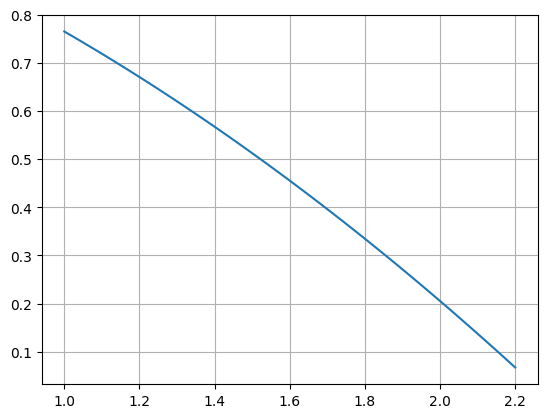

In [ ]:
graficar(sp.lambdify(s,interpolacion_lagrange),np.linspace(1,2.2))

Interpolación y Tabulación de Neville

In [ ]:
def Neville(f: list, s, pasa: int, grado: int):
    #Base de la recursion
    if(grado==0):
        return f[pasa].y
    else:
        return (
            (s-f[pasa-grado].x)*Neville(f,s,pasa,grado-1)-(s-f[pasa].x)*Neville(f,s,pasa-1,grado-1))/(f[pasa].x - f[pasa-grado].x)
def tabular_neville(f: list, valor: float,s):
    A=np.zeros((len(f),len(f)))
    for i in range(len(f)):
        for j in range(len(f)):
            if(j<i):
                A[j][i]=None
            else:
                A[j][i]=sp.lambdify(s,Neville(f,s,j,i))(valor)
    return pd.DataFrame(A, columns = [ str(i) for i in range(len(f))])

In [ ]:
x=[1.0 ,2 ,3 ,4, 6]
y=[np.exp(xi) for xi in x]
f=[datos(x[i],y[i]) for i in range(len(x))]
s=sp.symbols('x')
interpolacion_neville=sp.expand(Neville(f,s,4,3))
interpolacion_neville

8.93154251594079*x**3 - 69.4758165006174*x**2 + 190.376255524469*x - 166.912529075064

In [ ]:
tabular_neville(f,2.5,s)

,0,1,2,3,4
0,2.718282,NaN,NaN,NaN,NaN
1,7.389056,9.724443,NaN,NaN,NaN
2,20.085537,13.737297,12.734083,NaN,NaN
3,54.598150,2.829230,11.010280,11.872182,NaN
4,403.428793,-207.024833,37.804908,14.359608,12.61841


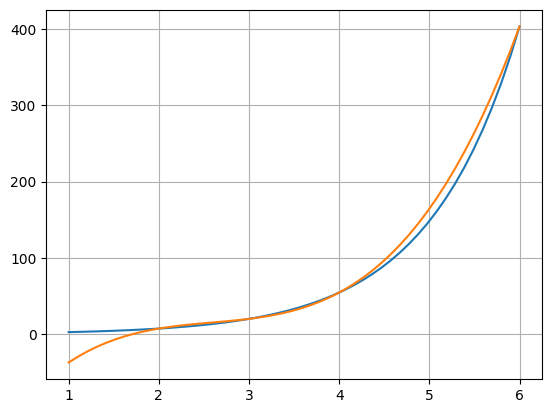

In [ ]:
graficar(sp.lambdify(s,interpolacion_neville),np.linspace(1,6),np.exp)

Interpolación de Newton por diferencias divididas

In [ ]:
def calcular_tabla_diferencias_divididas(f):
    xj=[p.x for p in f]
    yj=[p.y for p in f]
    n = len(xj)
    tabla = np.zeros((n, n))
    for i in range(n):
        tabla[i][0] = yj[i]
    for j in range(1, n):
        for i in range(j, n):
            tabla[i][j] = (tabla[i][j-1] - tabla[i-1][j-1]) / (xj[i] - xj[i-j])
    return tabla
def interpolar_newton_progresivo(f, Punto):
    xj=[p.x for p in f]
    Matriz_diferencias=calcular_tabla_diferencias_divididas(f)
    n = len(xj)
    Progresivo = Matriz_diferencias[0][0]
    Producto = 1
    for i in range(1, n):
        for j in range(i):
            Producto *= (Punto - xj[j])
        Progresivo += Matriz_diferencias[i][i] * Producto
        Producto = 1
    return Progresivo
def interpolar_newton_regresivo(f, Punto):
    xj=[p.x for p in f]
    Matriz_diferencias=calcular_tabla_diferencias_divididas(f)
    n = len(xj)
    Regresivo = Matriz_diferencias[n-1][0]
    Producto = 1
    for i in range(n-2, -1, -1):
        for j in range(n-1, i, -1):
            Producto *= (Punto - xj[j])
        Regresivo += Matriz_diferencias[n-1][n-1-i] * Producto
        Producto = 1
    return Regresivo
def mostrar_tabla_newton(f):
    tabla =calcular_tabla_diferencias_divididas(f)
    return pd.DataFrame(tabla)

In [ ]:
#x 1.0 1.3 1.6 1.9 2.2
#f (x) 0.7651977 0.6200860 0.4554022 0.2818186 0.1103623
x=[1.0, 1.3, 1.6, 1.9, 2.2]
y=[0.7651977, 0.6200860, 0.4554022, 0.2818186, 0.1103623]
f=[datos(x[i],y[i]) for i in range(len(x))]
mostrar_tabla_newton(f)

,0,1,2,3,4
0,0.765198,0.000000,0.000000,0.000000,0.000000
1,0.620086,-0.483706,0.000000,0.000000,0.000000
2,0.455402,-0.548946,-0.108734,0.000000,0.000000
3,0.281819,-0.578612,-0.049443,0.065878,0.000000
4,0.110362,-0.571521,0.011818,0.068069,0.001825


In [ ]:
s=sp.symbols('x')
Newton_progresivo=interpolar_newton_progresivo(f,s)
sp.lambdify(s,Newton_progresivo)(1.1)

0.7196459942386871

In [ ]:
s=sp.symbols('x')
Newton_regresivo=interpolar_newton_regresivo(f,s)
sp.lambdify(s,Newton_regresivo)(2)

0.22387536460905566

Código Splines

In [ ]:
class SplineCubicoNatural:
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = x
        self.y = y
        self.n = len(x)
        self.a, self.b, self.c, self.d = self.calcular_coeficientes()

    def calcular_coeficientes(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        h = np.diff(self.x)
        a_sobre_h = np.diff(self.y) / h

        Matriz_Asociada_Al_Sistema = np.zeros((self.n, self.n))
        Matriz_Asociada_Al_Sistema[0, 0] = 1
        Matriz_Asociada_Al_Sistema[-1, -1] = 1

        for i in range(1, self.n - 1):
            Matriz_Asociada_Al_Sistema[i, i - 1] = h[i - 1]
            Matriz_Asociada_Al_Sistema[i, i] = 2 * (h[i - 1] + h[i])
            Matriz_Asociada_Al_Sistema[i, i + 1] = h[i]

        Vector_B = np.zeros(self.n)
        Vector_B[1:-1] = 3 * (a_sobre_h[1:] - a_sobre_h[:-1])

        c = np.linalg.solve(Matriz_Asociada_Al_Sistema, Vector_B)
        a = self.y[:-1]
        b = a_sobre_h - h * (2 * c[:-1] + c[1:]) / 3
        d = (c[1:] - c[:-1]) / (3 * h)

        return a, b, c[:-1], d

    def evaluar(self, xi: np.ndarray) -> np.ndarray:
        k = np.searchsorted(self.x, xi.clip(self.x[0], self.x[-1])) - 1
        x_xk = xi - self.x[k]
        y_imagen = self.a[k] + self.b[k] * x_xk + self.c[k] * x_xk ** 2 + self.d[k] * x_xk ** 3
        return y_imagen

    def mostrar_polinomios(self) -> list[sp.Expr]:
        splines = []
        xs = sp.symbols('x')

        for i in range(self.n - 1):
            splines.append(sp.expand(self.a[i] + self.b[i] * (xs - self.x[i]) + self.c[i] * (xs - self.x[i])**2 + self.d[i] * (xs - self.x[i])**3))

        return splines

    def graficar_spline(self, a: float, b: float, n: int = 100, real: callable = None):
        splines = []
        colores = ['g', 'b', 'y']
        coeficientes = self.calcular_coeficientes()

        for i in range(self.n - 1):
            xs = np.linspace(self.x[i], self.x[i + 1], num=100)
            ys = coeficientes[0][i] + coeficientes[1][i] * (xs - self.x[i]) + coeficientes[2][i] * (xs - self.x[i]) ** 2 + coeficientes[3][i] * (xs - self.x[i]) ** 3
            splines.append((xs, ys))

        i = 0
        for spline in splines:
            plt.plot(spline[0], spline[1], colores[i % 3])
            i += 1

        plt.scatter(self.x, self.y, color='r', marker='*')

        if real is not None:
            xi = np.linspace(a, b, 100)
            yreal = real(xi)
            plt.plot(xi, yreal, label='Funcion real')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Interpolacion por Spline Cubico natural')
        plt.grid(True)
        plt.show()


class SplineCubicoFronteraFija:
    def __init__(self, x: np.ndarray, y: np.ndarray, a: float, b: float):
        self.x = x
        self.y = y
        self.n = len(x)
        self.frontera_a = a
        self.frontera_b = b
        self.a, self.b, self.c, self.d = self.calcular_coeficientes()

    def calcular_coeficientes(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        h = np.diff(self.x)
        a_sobre_h = np.diff(self.y) / h

        Matriz_Asociada_Al_Sistema = np.zeros((self.n, self.n))
        Matriz_Asociada_Al_Sistema[0, 0] = (-2 / 3) * h[0]
        Matriz_Asociada_Al_Sistema[0, 1] = -h[0] / 3
        Matriz_Asociada_Al_Sistema[-1, 2] = (1 / 3) * h[2]
        Matriz_Asociada_Al_Sistema[-1, 3] = (2 / 3) * h[2]

        for i in range(1, self.n - 1):
            Matriz_Asociada_Al_Sistema[i, i - 1] = h[i - 1]
            Matriz_Asociada_Al_Sistema[i, i] = 2 * (h[i - 1] + h[i])
            Matriz_Asociada_Al_Sistema[i, i + 1] = h[i]

        Vector_B = np.zeros(self.n)
        Vector_B[0] = self.frontera_a - ((self.y[1] - self.y[0]) / h[0])
        Vector_B[1:-1] = 3 * (a_sobre_h[1:] - a_sobre_h[:-1])
        Vector_B[-1] = self.frontera_b - ((self.y[self.n - 1] - self.y[self.n - 2]) / h[self.n - 2])

        c = np.linalg.solve(Matriz_Asociada_Al_Sistema, Vector_B)
        a = self.y[:-1]
        b = a_sobre_h - h * (2 * c[:-1] + c[1:]) / 3
        d = (c[1:] - c[:-1]) / (3 * h)

        return a, b, c[:-1], d

    def evaluar(self, xi: np.ndarray) -> np.ndarray:
        k = np.searchsorted(self.x, xi.clip(self.x[0], self.x[-1])) - 1
        x_xk = xi - self.x[k]
        y_imagen = self.a[k] + self.b[k] * x_xk + self.c[k] * x_xk ** 2 + self.d[k] * x_xk ** 3
        return y_imagen

    def mostrar_polinomios(self) -> list[sp.Expr]:
        splines = []
        xs = sp.symbols('x')

        for i in range(self.n - 1):
            splines.append(sp.expand(self.a[i] + self.b[i] * (xs - self.x[i]) + self.c[i] * (xs - self.x[i])**2 + self.d[i] * (xs - self.x[i])**3))

        return splines

    def graficar_spline(self, a: float, b: float, n: int = 100, real: callable = None):
        splines = []
        colores = ['g', 'b', 'y']
        coeficientes = self.calcular_coeficientes()

        for i in range(self.n - 1):
            xs = np.linspace(self.x[i], self.x[i + 1], num=100)
            ys = coeficientes[0][i] + coeficientes[1][i] * (xs - self.x[i]) + coeficientes[2][i] * (xs - self.x[i]) ** 2 + coeficientes[3][i] * (xs - self.x[i]) ** 3
            splines.append((xs, ys))

        i = 0
        for spline in splines:
            plt.plot(spline[0], spline[1], colores[i % 3])
            i += 1

        plt.scatter(self.x, self.y, color='r', marker='*')

        if real is not None:
            xi = np.linspace(a, b, 100)
            yreal = real(xi)
            plt.plot(xi, yreal, label='Funcion real')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Interpolacion por Spline Cubico frontera fija')
        plt.grid(True)
        plt.show()


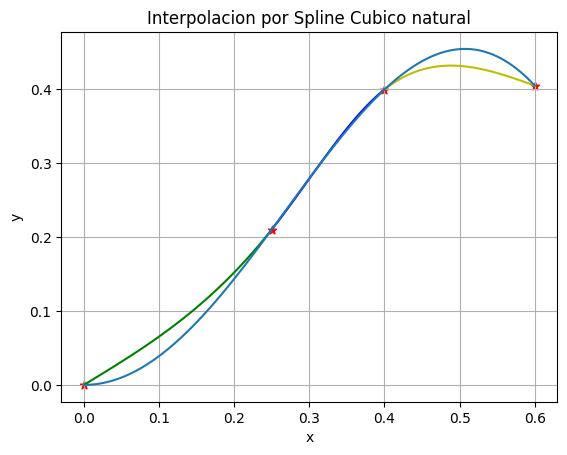

In [ ]:
x = np.array([0, 0.25, 0.4, 0.6])
y = x*np.sin(4*x)
spline1 = SplineCubicoNatural(x, y)
spline1.graficar_spline(0,0.6,real=lambda x: x*np.sin(4*x))

In [ ]:
spline1.mostrar_polinomios()

[3.57581568036066*x**3 + 0.617982504785355*x,
 -19.0066329835275*x**3 + 16.9368364979161*x**2 - 3.61622661969367*x + 0.352850760373252,
 9.78520513719478*x**3 - 17.6133692469506*x**2 + 10.203855678253*x - 1.48982687935297]

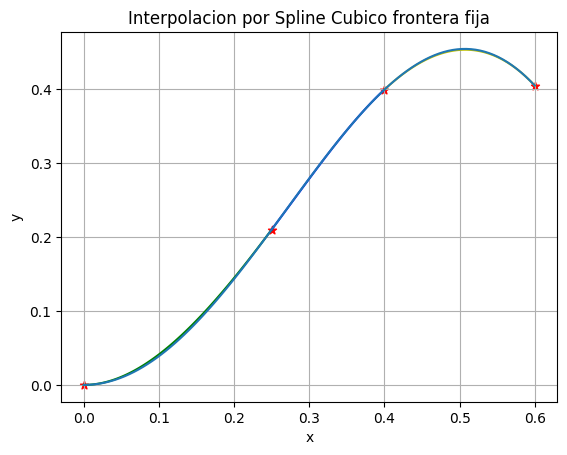

In [ ]:
x = np.array([0, 0.25, 0.4, 0.6])
y = x*np.sin(4*x)
y_prima= lambda x: np.sin(4*x) + 4*x*np.cos(4*x)
spline2 = SplineCubicoFronteraFija(x, y,y_prima(x[0]),y_prima(x[-1]))
spline2.graficar_spline(0,0.6,real=lambda x: x*np.sin(4*x))

In [ ]:
spline2.mostrar_polinomios()

[-5.13515716494795*x**3 + 4.64967323046857*x**2 - 1.11022302462516e-16*x,
 -9.71833260248896*x**3 + 8.08705480862433*x**2 - 0.859345394538939*x + 0.0716121162115782,
 -5.08169011807245*x**3 + 2.52308382732453*x**2 + 1.36624299798098*x - 0.225133002791078]

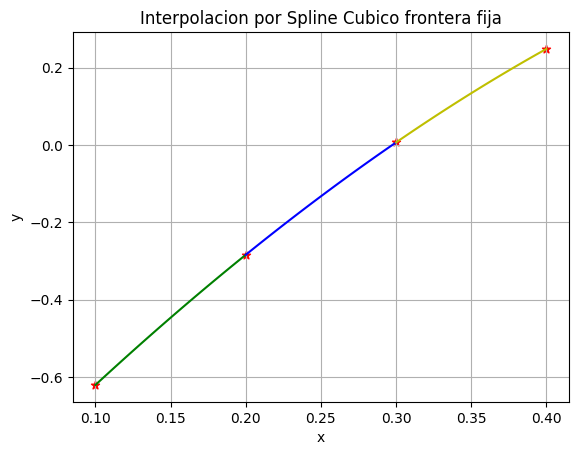

In [ ]:
x = np.array([0.1, 0.2 ,0.3, 0.4])
y = np.array([-0.62049958 ,-0.28398668 ,0.00660095 ,0.24842440])
spline3 = SplineCubicoFronteraFija(x, y,3.58502082,2.16529366)
spline3.graficar_spline(0.1,0.4)

In [ ]:
spline3.mostrar_polinomios()

[-0.49077413333335*x**3 - 2.00260854666665*x**2 + 4.00026575333333*x - 1.00000929573333,
 -0.474583600000065*x**3 - 2.01232286666663*x**2 + 4.00220861733333*x - 1.00013882,
 -0.449801466666531*x**3 - 2.03462678666681*x**2 + 4.00889979333338*x - 1.0008079376]